In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils_4 import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [5]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [6]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data + torch.randn(data.size()))
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.834656 32: 0.810205 64: 0.800534
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.688562 32: 0.664604 64: 0.610512
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.635825 32: 0.595030 64: 0.437822
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.653529 32: 0.521645 64: 0.326467
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.601505 32: 0.399990 64: 0.266803
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.568021 32: 0.334236 64: 0.233713
Test set:
16: loss: 0.5363	pho_loss: 0.0005
32: loss: 0.3429	pho_loss: 0.0015
64: loss: 0.2458	pho_loss: 0.0014

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.543340 32: 0.332470 64: 0.236322
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.447721 32: 0.275227 64: 0.196361
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.402862 32: 0.259800 64: 0.191861
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.374078 32: 0.248774 64: 0.202069
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.336917 32: 0.226698 64: 0.180367
Train

Test set:
16: loss: 0.1245	pho_loss: 0.0003
32: loss: 0.1000	pho_loss: 0.0002
64: loss: 0.0823	pho_loss: 0.0001

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.137273 32: 0.112373 64: 0.094495
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.130708 32: 0.104627 64: 0.085990
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.127911 32: 0.105349 64: 0.084384
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.130854 32: 0.104461 64: 0.088168
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.154870 32: 0.127048 64: 0.106423
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.134253 32: 0.111414 64: 0.092656
Test set:
16: loss: 0.1216	pho_loss: 0.0003
32: loss: 0.0983	pho_loss: 0.0002
64: loss: 0.0804	pho_loss: 0.0001

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.135399 32: 0.113871 64: 0.098431
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.137016 32: 0.116526 64: 0.102082
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.128211 32: 0.106215 64: 0.085125
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [10]:
data, _ = next(iter(test_loader))
output = models['64'](data) # то что выдала модель
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64)) # decoder по единичной матрице 64
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 3,  4,  4,  3,  0,  3,  2,  1,  2,  4,  3,  1,  3,  3,
         3,  1,  1,  1,  2,  3,  3,  3,  4,  2,  3,  0,  1,  3,
         2,  2,  5,  3,  3,  2,  4,  1,  1,  3,  2,  5,  3,  4,
         0,  4,  1,  0,  2,  2,  0,  0])


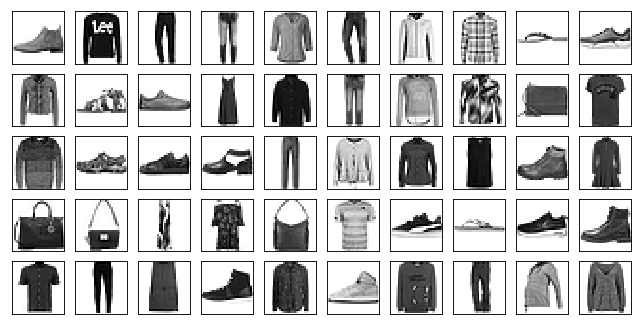

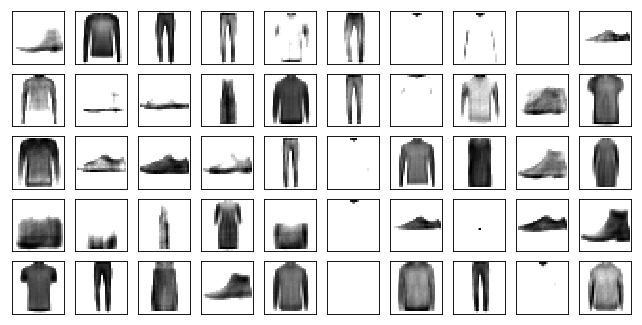

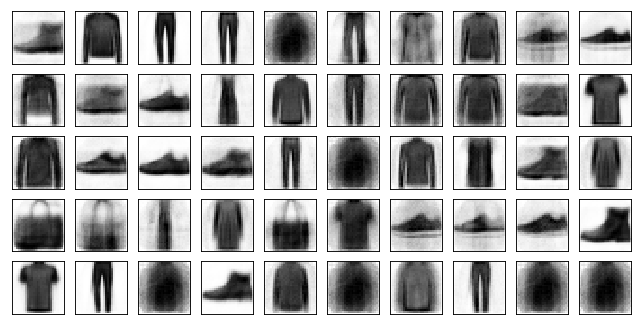

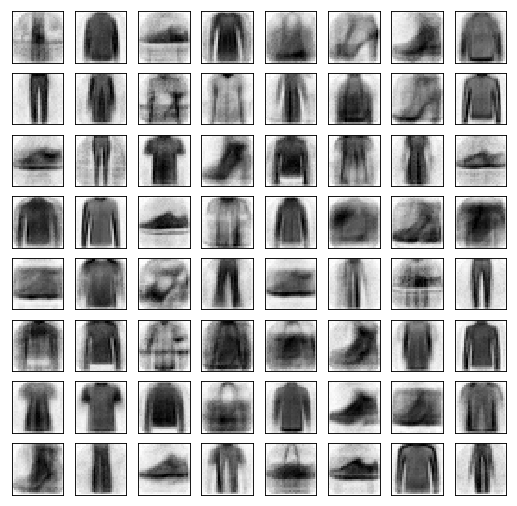

In [11]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))